In [92]:
import geopandas as gpd
import pandas as pd
import contextily as ctx

### Load Data

Data source: 
1. tax data: https://www.sfassessor.org/news-information/property-data-0
2. historic district data: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Map-of-Historic-Districts/y75h-nbt2
3. parcel data: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Parcels-Active-and-Retired/acdm-wktn
4. Other historic status data: https://data.sfgov.org/Housing-and-Buildings/Historic-Resources/3tsw-4idn

In [59]:
tax = pd.read_excel('./2023.7.18_SF_ASR_Secured_Roll_Data_2022-2023.xlsx')

In [60]:
historic = gpd.read_file('./Historic Districts/geo_export_a0505c4f-e263-4190-90bd-fe371826c801.shp')

In [61]:
historic = historic[['name_1', 'descriptio', 'geometry']]

In [62]:
parcels = gpd.read_file('./parcels/geo_export_ccf5bc9c-86d7-4a66-85d1-6e4ae4490c28.shp')

In [63]:
sites = pd.read_excel('./sf-sites-inventory-form-Dec-2022 - Copy.xlsx', skiprows=1,
                      sheet_name='Table A - Submitted- Dec-22')

In [64]:
rezoned = pd.read_excel('./sf-sites-inventory-form-Dec-2022 - Copy.xlsx', skiprows=1,
                      sheet_name='Table B -Submitted-Dec-22')

In [120]:
historic2 = gpd.read_file('./Historic_Resources/geo_export_5c00ac77-19ab-4775-8efe-c98834e9b497.shp')

In [123]:
historic2['ceqacode'] = historic2.ceqacode.map({'A': 'historic', 'B': 'unknown', 'C': 'not historic'})

In [124]:
historic2['ceqacode']

unknown         121003
historic         23883
not historic     18000
Name: ceqacode, dtype: int64

### Clean Assesor Parcel Number (aka blklot)

In [65]:
tax['blklot'] = tax.RP1PRCLID.str.replace(' ', '')

### Create geospatial version of tax assessor data so I can do a geospatial merge with the historic districts dataset

In [66]:
# better to merge on blklot than mapblklot
tax['blklot'].isin(parcels.blklot).mean()

0.9990404205132568

In [67]:
df = pd.merge(parcels[['blklot', 'geometry']], tax)

In [68]:
df.shape

(211348, 34)

In [69]:
# geospatial merge
full_df = gpd.sjoin(df, historic, predicate='within', rsuffix='historic', how='left')

In [70]:
full_df['is_historic'] = full_df['index_historic'].notna()

In [71]:
# join creates ~750 new rows bc these parcels are in multiple historic districts
full_df.shape[0] - df.shape[0]

746

In [72]:
# so, I drop extra matches
full_df = full_df.drop_duplicates(['PROPLOC', 'blklot', 'geometry'])

### How many parcels have buildings that are 100+ years old?

In [73]:
# When YRBLT is 0 or predates the country's founding, I interpret that as missing data
(full_df.YRBLT < 1776).mean().round(3)

0.056

In [74]:
((full_df['YRBLT'] > 1776) & (full_df['YRBLT'] <= 1923)).mean().round(3)

0.314

### How many parcels are in historic districts?

In [75]:
full_df['is_historic'].mean().round(3)

0.098

### How many parcels are in historic districts or have buildings that are 100+ years old?


In [76]:
# This is where the 41% figure came from
(full_df['is_historic'] | (full_df['YRBLT'] <= 1923)).mean().round(4)

0.4148

In [77]:
# Actual number is 36%
(full_df['is_historic'] | ((full_df['YRBLT'] > 1776) & (full_df['YRBLT'] <= 1923))).mean().round(3)

0.362

In [113]:
full_df_plot = full_df.copy()

In [114]:
full_df_plot['cua'] = full_df_plot['is_historic'] | ((full_df_plot['YRBLT'] > 1776) & (full_df_plot['YRBLT'] <= 1923))

In [115]:
full_df_plot['cua'] = full_df_plot['cua'].map({True: 'CUA', False: 'no CUA'})

### How many inventory sites are historic or 100+ years old?

In [78]:
sites.shape

(121053, 21)

In [79]:
sites['blklot'] = sites.mapblklot.str.replace('-', '')

In [80]:
sites.blklot.isin(full_df.blklot).mean()

0.9964974019644288

In [81]:
sites_df = pd.merge(full_df, sites, how='right')

In [82]:
sites.shape

(121053, 22)

In [83]:
(sites_df['is_historic'] | ((sites_df['YRBLT'] > 1776) & (sites_df['YRBLT'] <= 1923))).mean().round(3)

0.383

### And rezoned inventory sites?

In [84]:
rezoned.shape

(55178, 39)

In [85]:
rezoned['blklot'] = rezoned.mapblklot.str.replace('-', '')

In [86]:
rezoned.blklot.isin(full_df.blklot).mean()

0.999528797709232

In [87]:
rz_df = pd.merge(full_df, rezoned, how='right')

In [88]:
rz_df.shape

(55178, 77)

In [89]:
(rz_df['is_historic'] | ((rz_df['YRBLT'] > 1776) & (rz_df['YRBLT'] <= 1923))).mean().round(3)

0.323

In [105]:
rz_df['cua'] = rz_df['is_historic'] | ((rz_df['YRBLT'] > 1776) & (rz_df['YRBLT'] <= 1923))

In [106]:
rz_df['cua'] = rz_df['cua'].map({True: 'CUA', False: 'no CUA'})

Text(0.5, 1.0, 'CUA Applied to Site Inventory')

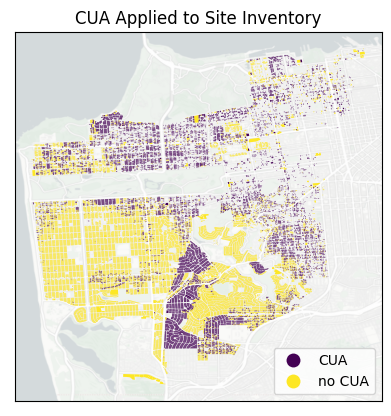

In [112]:
ax = rz_df.plot(column='cua', cmap='viridis', legend=True, legend_kwds={'loc': 'lower right'})
ctx.add_basemap(ax, crs=rz_df.crs, 
                source=ctx.providers.CartoDB.PositronNoLabels, 
                attribution=False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('CUA Applied to Site Inventory')

Text(0.5, 1.0, 'CUA Applied Citywide')

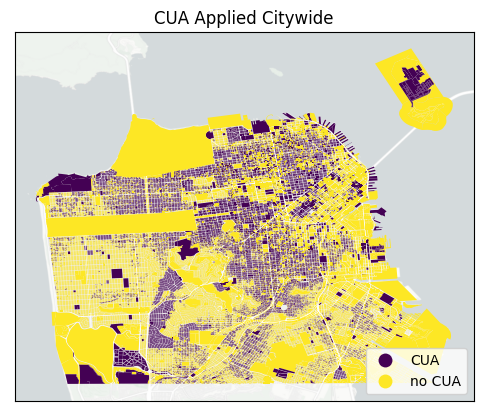

In [116]:
ax = full_df_plot.plot(column='cua', cmap='viridis', legend=True, legend_kwds={'loc': 'lower right'})
ctx.add_basemap(ax, crs=rz_df.crs, 
                source=ctx.providers.CartoDB.PositronNoLabels, 
                attribution=False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('CUA Applied Citywide')

### What if we include cities where it's unknown whether it's a historic resource?

In [128]:
historic_unknown = historic2[historic2.ceqacode.isin(('historic', 'unknown'))]

In [ ]:
historic_unknown.

Text(0.5, 1.0, 'Historical Status')

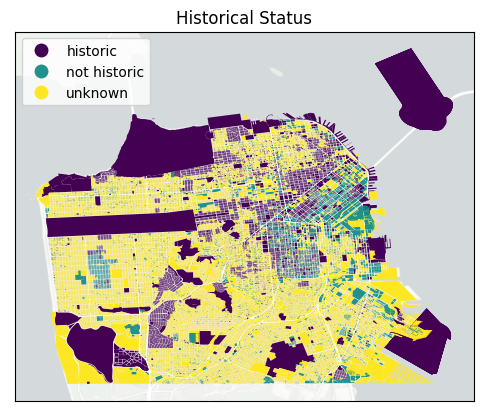

In [137]:
ax = historic2.plot(column='ceqacode', cmap='viridis', legend=True, legend_kwds={'loc': 'upper left'})
ctx.add_basemap(ax, crs=historic2.crs, 
                source=ctx.providers.CartoDB.PositronNoLabels, 
                attribution=False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('Historical Status')

In [129]:
gpd.sjoin(full_df, historic_unknown, predicate='within', how='left')

,blklot,geometry,PROPLOC,RP1PRCLID,RP1NBRCDE,RP1VOLUME,RP1CLACDE,YRBLT,BATHS,BEDS,...,ROLLYEAR,RECURRSALD,RP1FXTVAL,RP1IMPVAL,RP1LNDVAL,RP1PPTVAL,index_historic,name_1,descriptio,is_historic
0,0001001,"POLYGON ((-122.42200 37.80848, -122.42208 37.8...",0000 3001 HYDE ST0000,0001 001,08H,1,GG,1900,0,0,...,22,0,0,0,0,0,NaN,NaN,NaN,False
1,0002001,"POLYGON ((-122.42083 37.80863, -122.42086 37.8...",0000 3002 HYDE ST0000,0002 001,08H,1,IXG,1900,0,0,...,22,0,0,0,0,0,NaN,NaN,NaN,False
2,0004002,"POLYGON ((-122.41570 37.80833, -122.41576 37.8...",0000 0160 JEFFERSON ST0000,0004 002,08H,1,CG,0,0,0,...,22,0,0,0,0,0,NaN,NaN,NaN,False
3,0005001,"POLYGON ((-122.41735 37.80812, -122.41746 37.8...",0000 0286 JEFFERSON ST0000,0005 001,08H,1,CG,1900,0,0,...,22,0,0,0,0,0,NaN,NaN,NaN,False
4,0006001,"POLYGON ((-122.41897 37.80791, -122.41915 37.8...",0366 0350 JEFFERSON ST0000,0006 001,08H,1,CG,1900,0,0,...,22,0,0,0,0,0,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211343,0977C004,"POLYGON ((-122.44253 37.79155, -122.44259 37.7...",0000 2878 JACKSON ST0000,0977C004,07B,7,CO,0,2,2,...,22,180613,0,642478,900648,0,NaN,NaN,NaN,False
211344,0977C005,"POLYGON ((-122.44253 37.79155, -122.44259 37.7...",0000 2880 JACKSON ST0000,0977C005,07B,7,CO,1908,1,2,...,22,200603,0,638951,958426,0,NaN,NaN,NaN,False
211345,0977C006,"POLYGON ((-122.44253 37.79155, -122.44259 37.7...",0000 2882 JACKSON ST0000,0977C006,07B,7,CO,1908,2,3,...,22,161221,0,814764,814764,0,NaN,NaN,NaN,False
211346,0977C007,"POLYGON ((-122.44253 37.79155, -122.44259 37.7...",0000 2884 JACKSON ST0000,0977C007,07B,7,CO,1909,1,2,...,22,30725,0,434752,434752,0,NaN,NaN,NaN,False
